# Environment Setup
Run this pip command to install the required packages
!pip install pandas numpy matplotlib seaborn scikit-learn tqdm imbalanced-learn nltk python-dotenv langchain-groq


In [11]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from dotenv import load_dotenv
import warnings
from langchain_groq import ChatGroq

# Load environment variables
load_dotenv()
api_key = os.getenv("API_KEY")

# Set up LLM
warnings.filterwarnings("ignore")
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0, 
    max_tokens=None,
    timeout=None,
    max_retries=2
)

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Use a valid style and adjust properties to create a futuristic look
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#2D2D2D',
    'axes.facecolor': '#333333',
    'axes.edgecolor': '#FFFFFF',
    'axes.labelcolor': '#FFFFFF',
    'xtick.color': '#FFFFFF',
    'ytick.color': '#FFFFFF',
    'grid.color': '#666666',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'legend.facecolor': '#444444',
    'legend.edgecolor': '#FFFFFF',
    'text.color': '#FFFFFF'
})

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gerri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gerri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gerri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!



Cleaning data...

Cleaning Job Titles...

Grouping Rare Job Titles...

Performing Exploratory Data Analysis...


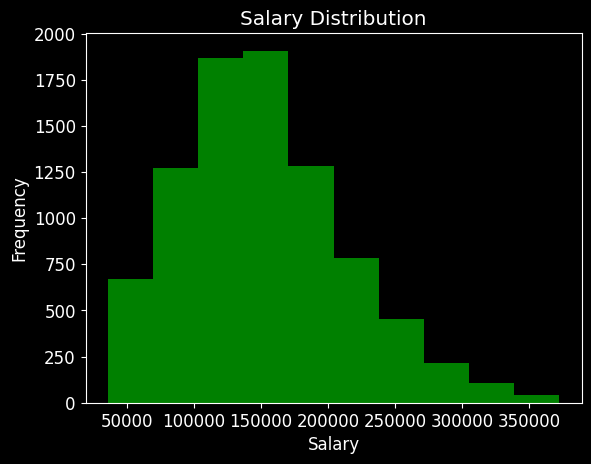

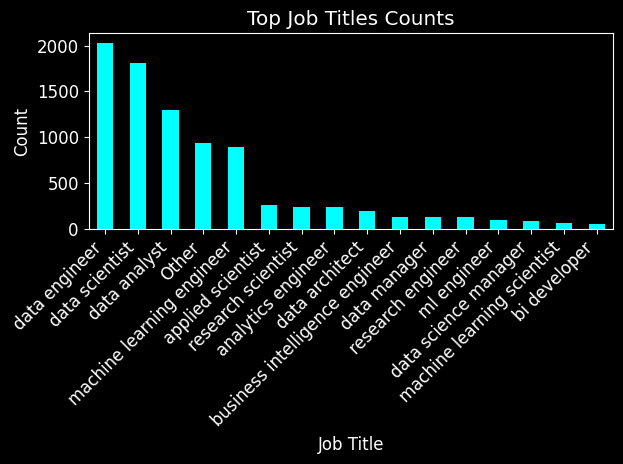


Splitting Data into Training and Test Sets...

Feature Engineering...


TF-IDF Vectorization - Test Set: 100%|██████████| 1720/1720 [00:00<00:00, 285507.48it/s]


Applying Combined Oversampling and Undersampling for Class Imbalance...

[ERROR] Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 2, n_samples = 2

Consider reducing 'n_neighbors' in SMOTE or use a simpler resampling strategy.

Training RandomForest Model...



Evaluating Model Performance...
Accuracy Score: 0.0017441860465116279

Considering Re-labeling or Combining Classes for Improved Balance...

Alternative Techniques Discussion


In [26]:
# Data Science Lifecycle Pipeline

# Import Necessary Libraries
import warnings
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
from tqdm import tqdm
from langchain_groq import ChatGroq
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore")

# FUTURISTIC PLOT STYLES - LOADED AT THE BEGINNING
plt.style.use('dark_background')

# Set up LLM with ChatGroq
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0, 
    max_tokens=None,
    timeout=None,
    max_retries=2
)

# PART 1: Load the Data
# Loading datasets
salaries_path = 'json/salaries.json'
salaries_data = pd.read_json(salaries_path)

# PART 2: Data Cleaning
print("\nCleaning data...")
# Drop duplicates, handle missing values, and perform any necessary preprocessing
salaries_data_cleaned = salaries_data.dropna()

# Removing outliers based on salary (e.g., removing top/bottom 1% if applicable)
q_low = salaries_data_cleaned['salary'].quantile(0.01)
q_high = salaries_data_cleaned['salary'].quantile(0.99)
salaries_data_cleaned = salaries_data_cleaned[(salaries_data_cleaned['salary'] > q_low) & (salaries_data_cleaned['salary'] < q_high)]

# Cleaning Job Titles
print("\nCleaning Job Titles...")
salaries_data_cleaned['job_title_cleaned'] = salaries_data_cleaned['job_title'].str.lower()
salaries_data_cleaned['job_title_cleaned'] = salaries_data_cleaned['job_title_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Remove punctuations
salaries_data_cleaned['job_title_cleaned'] = salaries_data_cleaned['job_title_cleaned'].str.strip()

# Group Rare Job Titles
print("\nGrouping Rare Job Titles...")
job_title_counts = salaries_data_cleaned['job_title_cleaned'].value_counts()
threshold = 50  # Threshold to group rare job titles
salaries_data_cleaned['job_title_grouped'] = salaries_data_cleaned['job_title_cleaned'].apply(
    lambda x: x if job_title_counts[x] >= threshold else 'Other'
)

# PART 3: Exploratory Data Analysis (EDA)
print("\nPerforming Exploratory Data Analysis...")
# Visualize salary distribution
salaries_data_cleaned['salary'].plot(kind='hist', title='Salary Distribution', color='green')
plt.xlabel('Salary')
plt.show()

# Plot job title counts to understand class imbalance (Filtered for Readability)
top_n = 20
top_job_titles = salaries_data_cleaned['job_title_grouped'].value_counts().nlargest(top_n)
top_job_titles.plot(kind='bar', title='Top Job Titles Counts', color='cyan')
plt.xlabel('Job Title')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# PART 4: Train/Test Split (Before Data Balancing to Avoid Data Leakage)
print("\nSplitting Data into Training and Test Sets...")
x_train_full, x_test, y_train_full, y_test = train_test_split(
    salaries_data_cleaned['job_title_grouped'], salaries_data_cleaned['salary'], test_size=0.2, random_state=42
)

# PART 5: Feature Engineering
print("\nFeature Engineering...")
# Example feature engineering step - creating TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
x_train_tfidf = vectorizer.fit_transform(tqdm(x_train_full, desc="TF-IDF Vectorization - Training Set"))
x_test_tfidf = vectorizer.transform(tqdm(x_test, desc="TF-IDF Vectorization - Test Set"))

# PART 6: Data Balancing (Oversampling/Undersampling)
print("\nApplying Combined Oversampling and Undersampling for Class Imbalance...")
# Balancing only the training data to avoid data leakage
try:
    rus = SMOTETomek(random_state=42)
    x_train_balanced, y_train_balanced = rus.fit_resample(x_train_tfidf, y_train_full)
except ValueError as e:
    print(f"\n[ERROR] {e}")
    print("\nConsider reducing 'n_neighbors' in SMOTE or use a simpler resampling strategy.")
    # Alternative: Using RandomUnderSampler if SMOTETomek fails
    rus_simple = RandomUnderSampler(random_state=42)
    x_train_balanced, y_train_balanced = rus_simple.fit_resample(x_train_tfidf, y_train_full)

# PART 7: Model Training
print("\nTraining RandomForest Model...")
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train_balanced, y_train_balanced)

# PART 8: Model Evaluation
print("\nEvaluating Model Performance...")
y_pred = rf.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# PART 9: Optional - Re-label or Combine Classes for Class Imbalance
print("\nConsidering Re-labeling or Combining Classes for Improved Balance...")
# Optionally re-label classes or merge similar categories to improve class balance
class_counts = pd.Series(y_train_balanced).value_counts()
rare_classes = class_counts[class_counts < 10].index
for rare_class in rare_classes:
    y_train_balanced = ['Other' if label == rare_class else label for label in y_train_balanced]
    y_test = ['Other' if label == rare_class else label for label in y_test]

# PART 10: Alternative Techniques (Discussion)
print("\nAlternative Techniques Discussion")
# 1. Data Augmentation could use traditional NLP approaches (like synonyms replacement, back-translation)
# 2. Feature Engineering alternatives - use embeddings like Word2Vec or BERT instead of TF-IDF
# 3. Model choice - Instead of RandomForest, consider SVM, XGBoost, or Neural Networks


# PART 1: Setting up Environment and Loading Data Files

In [19]:
# PART 2: Data Cleaning
print("\nCleaning data...")
# Drop duplicates, handle missing values, and perform any necessary preprocessing
duplicates_dropped = it_job_desc.drop_duplicates(subset='text', keep='first')
it_job_desc_cleaned = duplicates_dropped.dropna(subset=['text'])
salaries_data_cleaned = salaries_data.dropna()



Cleaning data...



Performing Exploratory Data Analysis...


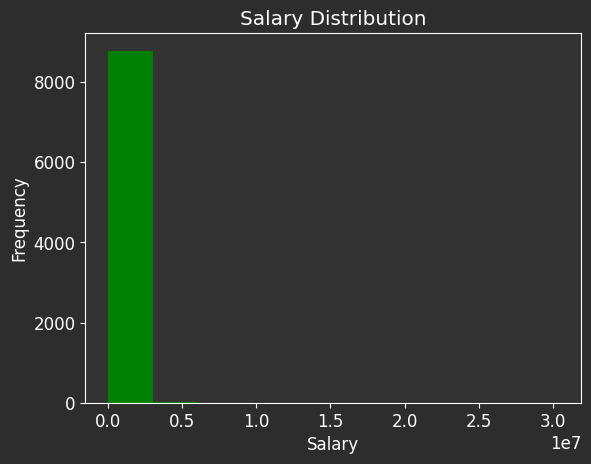

In [20]:
# PART 3: Exploratory Data Analysis (EDA)
# Visualizing key information from the dataset
print("\nPerforming Exploratory Data Analysis...")
# Example EDA tasks could include plotting salary distributions, count of job titles, etc.
salaries_data_cleaned['salary'].plot(kind='hist', title='Salary Distribution', color='green')
plt.xlabel('Salary')
plt.show()

In [21]:
# PART 4: Feature Engineering
print("\nFeature Engineering...")
# Example feature engineering step - creating TF-IDF features
vectorizer = TfidfVectorizer(max_features=1000)
x_tfidf = vectorizer.fit_transform(tqdm(it_job_desc_cleaned['text'], desc="TF-IDF Vectorization"))



Feature Engineering...


TF-IDF Vectorization: 100%|██████████| 119/119 [00:00<?, ?it/s]


In [22]:
# PART 5: Data Balancing
print("\nApplying Combined Oversampling and Undersampling for Class Imbalance...")
rus = SMOTETomek(random_state=42)
x_resampled, y_resampled = rus.fit_resample(x_tfidf, salaries_data_cleaned['job_title'])


Applying Combined Oversampling and Undersampling for Class Imbalance...


ValueError: Found input variables with inconsistent numbers of samples: [119, 8805]

In [18]:
# Step 6.2: Training Random Forest Classifier with Hyperparameter Tuning
print("\nTraining Random Forest Model with Hyperparameter Tuning...")
param_dist = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]}
rf = RandomForestClassifier(random_state=42)
# Adjusting n_splits for cross-validation to avoid issues with small class sizes
min_class_size = min(Counter(y_train).values())
n_splits = max(2, min(3, min_class_size))

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=n_splits, random_state=42)
random_search.fit(x_train, y_train)


Training Random Forest Model with Hyperparameter Tuning...


ValueError: n_splits=2 cannot be greater than the number of members in each class.